# Problem Statement

This project applies **Modern Portfolio Theory (MPT)** to real market data from major U.S. stocks.  
The goal is to explore the trade-off between **risk and return** by constructing and analyzing optimized portfolios.  

We compute and visualize:  
- The **Global Minimum Variance (GMV) portfolio**  
- The **Tangency portfolio (Max Sharpe Ratio)**  
- The **Efficient Frontier** and the **Capital Market Line (CML)**  

The code is **fully commented** with the aim of learning both the **financial concepts** and their **Python implementation**.  


### Financial Context: Imports & Setup 
We use **Yahoo Finance** to fetch historical stock data, **NumPy/Pandas** for matrix math, and plotting libraries for visualization. This is the foundation for portfolio optimization, where we rely on historical returns and covariances to model risk-return tradeoffs.

In [1]:
# Imports & basic config
import numpy as np
import pandas as pd
import scipy.optimize as opt

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
from matplotlib.ticker import FuncFormatter

import yfinance as yf

RNG = np.random.default_rng(42) # Set seed for reproducibility
trading_days = 252 
rf = 0.035  # annual risk-free rate

**Why use trading_days = 252?**  

- **Convention:** In both academia and industry, 252 is the standard assumption for trading days in a year.  
- **Reality:** The actual number varies (≈ 250–253) depending on weekends and holidays.  
- **Reason:** Using 252 ensures consistency and comparability across datasets, models, and years.  
- **Note:** For precise backtests, you can count the actual trading days in your sample, but 252 is the accepted norm.  


**Why rf = 0.035?**

- `rf` is the **risk-free rate**, usually proxied by short-term government bonds. 
- "s-t gov. bonds": A bond issued by a government that **matures in less than 1 year** (e.g., 3-month U.S. Treasury bill).  
- Considered **very safe** because default risk is extremely low and the short term reduces interest rate risk.  
- Used as a **proxy for the risk-free asset**, i.e., to define the risk-free rate in portfolio models.  
- The value `0.035` = 3.5% per year, chosen here as a **reasonable fixed assumption** for demonstration.  
- In practice, you would fetch the **actual current rate** (e.g. from FRED or Yahoo Finance) and convert it to match your data frequency.  
- Explained simply: "what the market is offering today on a near risk-free asset."


### Financial Context: Data Loading
This function downloads adjusted closing prices for the selected tickers and converts them into **log-returns**, which are additive across time and commonly used in finance. The mean of log-returns is used as expected return, and their covariance measures co-movement (risk).

In [2]:
# Data loading and preprocessing
def get_prices_and_logret(tickers, start='2020-01-01', auto_adjust=True):
    # Download historical price data from Yahoo Finance for the selected tickers
    raw = yf.download(tickers, start=start, auto_adjust=auto_adjust)
    # auto_adjust=True ensures prices are adjusted for splits/dividends

    # Take the 'Close' price column, fill missing values (forward fill), drop any remaining NaNs.
    prices = raw['Close'].ffill().dropna()
    # ffill() replaces the missing value with the last available price.

    # Ensure data is sorted by date (oldest to newest)
    prices = prices.sort_index()

    # Compute daily log-returns: r_t = ln(P_t / P_{t-1}), drop NaNs from the first shift.
    logret = np.log(prices / prices.shift(1)).dropna()

    return prices, logret

# Stats
def compute_stats(logret, trading_days=252):
    # Annualized expected return
    mu = logret.mean() * trading_days

    # Annualized covariance matrix (Σ): measures how returns move together, scaled to yearly units
    cov = logret.cov() * trading_days

    # Annualized volatility (std dev) for each asset
    ann_vol = pd.Series(np.sqrt(np.diag(cov.values)), index=logret.columns, name='ann_vol')
    
    return mu, cov, ann_vol

Quick summary:
- Prices: Adjusted closing prices of assets.
- `logret` (Log-returns): Daily logarithmic returns, additive over time, better for modeling risk/return.
- `mu` (expected return): The mean return an investor expects per year for each asset.
- `cov` (covariance matrix): Measures co-movement between asset returns, used to quantify portfolio risk.
- `ann_vol` (annualized volatility): Standard deviation of yearly returns for each asset; a common risk measure.

### Financial Context: Random Portfolio Sampling
We randomly generate portfolio weights (ensuring they sum to 1) to simulate many possible allocations. For each portfolio, we compute return and volatility. This creates a cloud of portfolios that helps us visualize the **feasible set** of risk-return combinations.

In [3]:
# Function to generate random portfolios and compute their return, risk, and Sharpe ratio
def sample_random_portfolios(mu, cov, B=50000, alpha=0.3, rng=RNG):
    # Number of assets in the portfolio
    N = len(mu)

    # Generate B random portfolios using a Dirichlet distribution (ensures weights sum to 1)
    W = rng.dirichlet([alpha] * N, size=B)
    # alpha controls concentration; smaller alpha → more extreme (sparse) allocations

    # Compute expected return of each portfolio: R_p = w.T * mu
    # Here W: B x N matrix, mu.values: N x 1 vector
    ret = W @ mu.values
    # We use @ for matrix multiplication (equivalent to np.dot() or np.matmul())

    # Compute portfolio volatility (standard deviation) ~ risk
    # Using Einstein summation for efficient computation: σ_p = sqrt(w^T * Σ * w)
    vol = np.sqrt(np.einsum('bi,ij,bj->b', W, cov.values, W))

    # Compute Sharpe ratio: SR = (R_p - rf) / σ_p
    sharpe = (ret - rf) / np.where(vol == 0, np.nan, vol)
    # If volatility is 0, avoid division by zero → assign NaN

    # Create a DataFrame to store expected return, volatility, and Sharpe ratio for each random portfolio
    rand = pd.DataFrame({'ret': ret, 'vol': vol, 'sharpe': sharpe})
    # Add the actual portfolio weights as a column of lists
    rand['weights'] = list(W)
    
    return rand, W

### Comment on the matrix multiplication implimentation and alternatives

For each portfolio we compute the volatility as $w^T \Sigma w$. \
So for each b-portfolio: 
$
\sigma_b^2 = \sum_{i=1}^N \sum_{j=1}^N \, W[b,i] \, \Sigma[i,j] \, W[b,j]
$

- W = B × N (B portfolios, N assets)
- Σ = N × N (covariance matrix)

- `einsum` handles the batch computation efficiently without explicit Python loops.
- That line computes $w^T \Sigma w$ for every row of W at once (all B portfolios).

Alternative, explicit use of for loops
instead of: vol = np.sqrt(np.einsum('bi,ij,bj->b', W, cov.values, W))
```python
B, N = W.shape  # number of portfolios, number of assets
vol = np.zeros(B)  # initialize array to store volatilities

for b in range(B):  # loop over each portfolio
    sigma = 0.0
    for i in range(N):  # loop over assets for row of covariance
        for j in range(N):  # loop over assets for column of covariance
            sigma += W[b, i] * cov.values[i, j] * W[b, j]  # w_i * cov_ij * w_j
    vol[b] = np.sqrt(sigma)  # take square root to get volatility
```

Alternative, very slow for large numbers
It computes a whole big matrix just to extract the diagonal
```python
C   = np.dot(np.dot(W, cov.values), W.T) # or C = W @ cov.values @ W.T
vol = np.sqrt(np.diag(C))
```

Quick Summary:
- `mu`: Expected return vector of each asset (annualized).
- `cov`: Covariance matrix of asset returns (annualized), measures co-movement and risk.
- `W`: Matrix of portfolio weights (rows = portfolios, columns = assets). Sum of each row = 1.
- `ret`: Expected portfolio return for each random portfolio (weighted sum of mu).
- `vol`: Portfolio volatility (risk), computed from the covariance matrix and weights.
- `sharpe`: Risk-adjusted return of each portfolio: (return − risk-free rate) / volatility.
- `B`: Number of random portfolios to simulate.
- `alpha`: Parameter controlling weight distribution concentration in Dirichlet sampling

### Financial Context: Portfolio Metrics
Helper functions compute portfolio **expected return** and **volatility (risk)** given weights. These are central to Modern Portfolio Theory (Markowitz), where investors balance risk vs return.

In [4]:
# Portfolio metric helpers 
def port_ret(w, mu):
    return float(w @ mu.values)
def port_var(w, cov):
    return float(w @ cov.values @ w)
def port_vol(w, cov):
    return float(np.sqrt(port_var(w, cov)))
def neg_sharpe(w, mu, cov, rf_val=rf):
    v = port_vol(w, cov)
    return 1e6 if v == 0 else - (port_ret(w, mu) - rf_val) / v
def pretty_weights(w, tickers, top=20, pct=True):
    s = pd.Series(w, index=tickers).sort_values(ascending=False).head(top)
    return (s * 100).round(2) if pct else s

Quick summary:
- `port_ret`: Expected return $ R_p = w^T \mu $ (Weighted average return of portfolio)
- `port_var`: Portfolio variance $ \sigma_p^2 = w^T \Sigma w $ (Risk measure accounting for covariances)
- `port_vol`: Portfolio volatility $ \sigma_p $ (Standard deviation of portfolio returns)
- `neg_sharpe`: Negative Sharpe ratio $ (R_p - r_f) / \sigma_p $ (Risk-adjusted return for optimization (maximizing Sharpe))
- `pretty_weights`: Portfolio allocation (Display top-weighted assets in readable form)

### Financial Context: GMV & Tangency Portfolios
**Global Minimum Variance (GMV) Portfolio:**
- Portfolio with the lowest possible risk (volatility)
- Ignores expected returns
- Found by minimizing portfolio variance
- Long-only & fully invested: weights are ≥0 and sum to 1

**Tangency Portfolio:**
- Portfolio that maximizes the Sharpe ratio
- Balances risk and excess return over the risk-free rate
- Key point on the efficient frontier: highest risk-adjusted return


In [5]:
# Optimization: GMV and Tangency (long-only, fully invested)
def compute_gmv_and_tangency(mu, cov, rf_val=rf):
    tickers = list(mu.index)    # list of asset names
    N = len(tickers)            # No. assets
    x0 = np.repeat(1.0 / N, N)  # initial guess: equal weights
    bounds = [(0.0, 1.0)] * N   # long-only: weights between 0 and 1 (no shorting)
    cons_sum = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0} # fully invested

    # Compute GMV portfolio (minimize portfolio variance)
    res_gmv = opt.minimize(fun=lambda w: w @ cov.values @ w, # We use `scipy.optimize.minimize`
                           x0=x0, 
                           method='SLSQP', # Sequential Least Squares Programming (handles constraints)  
                           bounds=bounds, 
                           constraints=[cons_sum],
                           options={'ftol': 1e-12, 'maxiter': 20000}) # Tolerance & max iterations
    
    assert res_gmv.success, res_gmv.message # check if optimizer converged successfully
    w_gmv = res_gmv.x
    R_gmv = port_ret(w_gmv, mu)
    V_gmv = port_vol(w_gmv, cov)

    # Compute Tangency portfolio (maximize Sharpe ratio)
    res_tan = opt.minimize(fun=lambda w: neg_sharpe(w, mu, cov, rf_val), 
                           x0=x0,
                           method='SLSQP', 
                           bounds=bounds, 
                           constraints=[cons_sum],
                           options={'ftol': 1e-12, 'maxiter': 20000})
    assert res_tan.success, res_tan.message

    w_tan = res_tan.x
    R_tan = port_ret(w_tan, mu)
    V_tan = port_vol(w_tan, cov)
    S_tan = (R_tan - rf_val) / V_tan if V_tan > 0 else np.nan
    
    return {
        'w_gmv': w_gmv, 'R_gmv': R_gmv, 'V_gmv': V_gmv,
        'w_tan': w_tan, 'R_tan': R_tan, 'V_tan': V_tan, 'S_tan': S_tan,
        'tickers': tickers
    }

### Financial Context: Efficient Frontier
- The **efficient frontier** is the set of portfolios that provide the **lowest risk (volatility) for a given return**.
- Each point on the frontier is **optimal**: no portfolio exists with the same return and lower risk.

In [6]:
# Efficient frontier builder (min variance for given returns)
def build_frontier(mu, cov, R_gmv, R_tan, w_tan, n_points=200):
    '''Returns arrays of volatility and return for portfolios along the frontier'''

    # Maximum individual expected return (ceiling)
    mu_ceiling = float(mu.max())

    # Lower and upper bounds for target returns
    r_lo = min(R_gmv, float(np.quantile(rand['ret'].values, 0.01))) if 'rand' in globals() else R_gmv
    r_hi = max(R_tan, float(np.quantile(rand['ret'].values, 0.995))) if 'rand' in globals() else R_tan
    r_hi = min(r_hi * 1.02, mu_ceiling * 0.995)

    # Generate linearly spaced target returns along the frontier
    targets = np.linspace(r_lo, r_hi, n_points)
    targets = np.unique(np.r_[targets, R_tan]) # ensure tangency return is included

    # Prepare containers for results
    frontier_vol = []   # volatilities
    frontier_ret = []   # returns
    frontier_w = []     # weights

    # Initial guess & constraints
    x0 = np.repeat(1.0 / len(mu), len(mu))
    bounds = [(0.0, 1.0)] * len(mu)
    cons_sum = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

    # Loop over target returns
    for tr in targets:
        # Add constraint: portfolio return must equal target
        cons_ret = {'type': 'eq', 'fun': lambda w, tr=tr: w @ mu.values - tr}

        # Minimize portfolio variance under constraints
        res = opt.minimize(lambda w: w @ cov.values @ w, x0, method='SLSQP',
                           bounds=bounds, constraints=[cons_sum, cons_ret],
                           options={'ftol': 1e-12, 'maxiter': 40000})
        
        # If optimization successful and weights valid, store results
        if res.success and abs(res.x.sum() - 1) < 1e-6 and res.x.min() >= -1e-10:
            w = res.x
            frontier_w.append(w)
            frontier_vol.append(np.sqrt(w @ cov.values @ w))
            frontier_ret.append(float(w @ mu.values))
            x0 = w # warm start next optimization with current solution

    # Convert results to arrays
    return np.asarray(frontier_vol, float), np.asarray(frontier_ret, float), frontier_w

### Financial Context: Visualization
Plots help illustrate the random portfolio cloud, efficient frontier, GMV, tangency portfolio, and the **Capital Market Line (CML)**. These visuals make the tradeoff between risk and return tangible.

In [7]:
# Plotting helper for combined visual (cloud, frontier, GMV, tangency, CML)
def plot_frontier_and_cml(rand, frontier_vol, frontier_ret, opt_res, rf_val=rf):
    # Convert frontier results to flat numpy arrays
    fv = np.asarray(frontier_vol, dtype=float).ravel()
    fr = np.asarray(frontier_ret, dtype=float).ravel()

    # Create figure
    plt.figure(figsize=(9,6))
    
    # Plot random portfolio cloud (blue dots)
    if rand is not None:
        plt.scatter(rand['vol'], rand['ret'], s=6, alpha=0.2, 
                    label='Random Portfolios', color='blue')
        
    # Plot efficient frontier (sorted by volatility)
    if fv.size > 0:
        order = np.argsort(fv) # sort portfolios by vol
        plt.plot(fv[order], fr[order], linewidth=2, 
                 label='Efficient Frontier')
        
    # Plot GMV (gold circle) and Tangency portfolio (red star)
    plt.scatter([opt_res['V_gmv']], [opt_res['R_gmv']], s=110, marker='o', label='GMV', color='gold')
    plt.scatter([opt_res['V_tan']], [opt_res['R_tan']], s=160, marker='*', label='Max Sharpe', color='red')

    # Capital Market Line (CML) — straight line through (0, rf) and tangency portfolio
    slope = (opt_res['R_tan'] - rf_val) / opt_res['V_tan'] if opt_res['V_tan'] > 0 else 0.0
    ax = plt.gca()
    xmax = 1.05 * max(
        float(fv.max()) if fv.size else 0.0, 
        float(rand['vol'].max()) if rand is not None else 0.0, 
        float(opt_res['V_tan']))
    
    xs = np.linspace(0.0, xmax, 120)
    plt.plot(xs, rf_val + slope * xs, linestyle='--', linewidth=1.3, 
             label='Capital Market Line')
    
    # Plot risk-free asset as black dot at (0, rf)
    plt.scatter([0.0], [rf_val], s=120, marker='o', color='black', 
                label=f'Risk-free ({rf_val*100:.1f}%)')
    
    # Format axes in percentages
    pct = FuncFormatter(lambda v, _: f'{v*100:.0f}%')
    ax.xaxis.set_major_formatter(pct)
    ax.yaxis.set_major_formatter(pct)

    # Labels and title
    plt.xlabel('Volatility (annual)')
    plt.ylabel('Return (annual)')
    plt.title('Efficient Frontier, GMV, Tangency and CML')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Financial Context: Capital Market Line (CML)
The CML represents combinations of the risk-free asset and the tangency portfolio. Investors can choose their desired risk level by mixing between the two, achieving higher efficiency than any risky-only portfolio.

In [8]:
# Utility functions for mixing between risk-free asset and tangency portfolio along the CML

# Mix by specifying a target RETURN
def cml_mix_by_return(R_target, R_tan, V_tan, w_tan, rf_val=rf, allow_leverage=False):
    denom = (R_tan - rf_val)
    if denom <= 0:
        raise ValueError('Tangency return must exceed RF for CML mixing.')
    
    # fraction invested in tangency portfolio (alpha)
    alpha = (R_target - rf_val) / denom

    # if leverage not allowed, clamp alpha to [0, 1]
    if not allow_leverage:
        alpha = np.clip(alpha, 0.0, 1.0)
    
    w_rf = 1.0 - alpha       # weight in risk-free asset
    w_risk = alpha * w_tan   # scaled weights in tangency portfolio
    R = rf_val + alpha * (R_tan - rf_val)  # portfolio return
    V = abs(alpha) * V_tan   # portfolio volatility (scaled by alpha)

    return w_rf, w_risk, float(R), float(V), float(alpha)

# Mix by specifying a target VOLATILITY
def cml_mix_by_vol(V_target, R_tan, V_tan, w_tan, rf_val=rf, allow_leverage=False):
    if V_tan <= 0:
        raise ValueError('Tangency volatility must be positive.')
    
    alpha = V_target / V_tan
    
    if not allow_leverage:
        alpha = np.clip(alpha, 0.0, 1.0)
    
    w_rf = 1.0 - alpha
    w_risk = alpha * w_tan
    R = rf_val + alpha * (R_tan - rf_val)
    V = abs(alpha) * V_tan
    
    return w_rf, w_risk, float(R), float(V), float(alpha)

# Build a table of portfolio mixes for a range of target RETURNS
def cml_table_by_return(target_returns, w_tan, R_tan, V_tan, rf_val=rf, allow_leverage=False, tickers=None):
    rows = []
    for Rt in np.asarray(target_returns, float):
        # compute portfolio mix for this target return
        w_rf, w_risky, R, V, alpha = cml_mix_by_return(
            Rt, R_tan, V_tan, w_tan, rf_val=rf_val, allow_leverage=allow_leverage)
        
        # record row with portfolio stats
        row = {'R_target': Rt, 'R': R, 'V': V, 'alpha': alpha, 'w_RF': w_rf}

        # optionally include risky weights broken down by ticker
        if tickers is not None:
            row.update({t: w for t, w in zip(tickers, w_risky)})

        rows.append(row)

    # return as a DataFrame
    return pd.DataFrame(rows)

- **Capital Market Line (CML):**  
  Any portfolio on the CML is a combination of:  
  - A **risk-free asset** (e.g., government bond, with zero volatility)  
  - The **tangency portfolio** (the optimal risky portfolio with maximum Sharpe ratio).  

- **Alpha (α):**  
  The fraction of wealth allocated to the tangency portfolio:  
  - $ \alpha = 0 $: 100% in the risk-free asset  
  - $ \alpha = 1 $: 100% in the tangency portfolio  
  - $ \alpha > 1 $: leveraged portfolio (borrowing at the risk-free rate to invest more in the tangency portfolio)  

- **Mixing strategies:**  
  - `cml_mix_by_return`: construct a portfolio given a **target expected return**.  
  - `cml_mix_by_vol`: construct a portfolio given a **target volatility**.  

- **Table builder:**  
  - `cml_table_by_return`: generates a DataFrame of portfolio statistics (return, volatility, risk-free weight, risky weights, etc.) for a set of target returns.


## RUN: minimal pipeline using the functions above

[*********************100%***********************]  20 of 20 completed


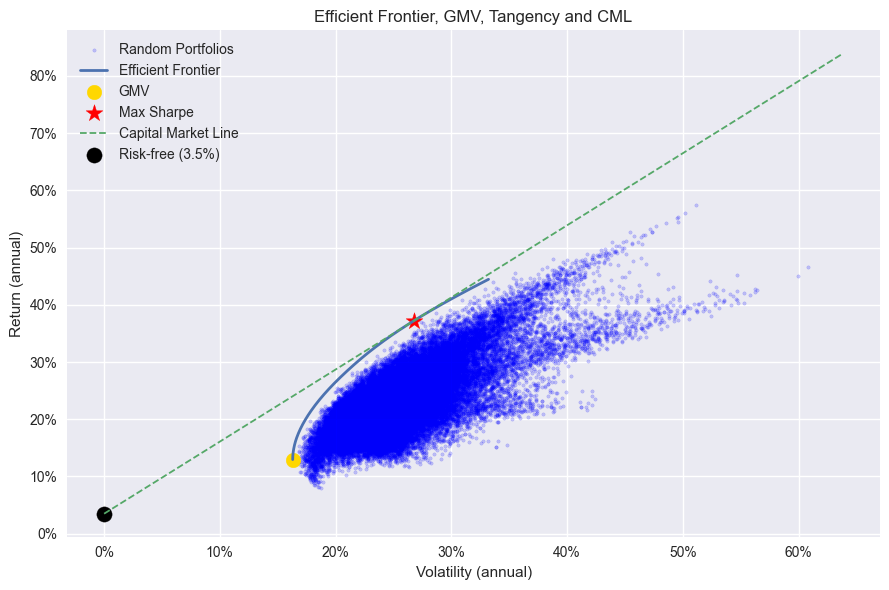

GMV portfolio expected return and volatility:
R=0.1296 V=0.1629

Tangency portfolio expected return, volatility, and Sharpe ratio:
R=0.3717 V=0.2673 Sharpe=1.260

Top weights (Tangency):
LLY     32.44
NVDA    22.54
WMT     20.51
AVGO    11.26
ORCL     8.24
TSLA     4.30
COST     0.72
XOM      0.00
MA       0.00
JNJ      0.00


In [9]:
# List of selected stock tickers (large-cap US companies across sectors)
tickers = ['NVDA','MSFT','AAPL','AMZN','META','AVGO','GOOGL','TSLA','BRK-B','JPM','ORCL','WMT','LLY','V','MA','NFLX','XOM','COST','JNJ','HD']

# Download historical adjusted prices and compute log returns since 2010
prices, logret = get_prices_and_logret(tickers, start='2020-01-01')

# Compute expected returns (mu), covariance matrix (cov), and annualized volatility (ann_vol)
mu, cov, ann_vol = compute_stats(logret, trading_days=trading_days)

# Generate 50,000 random portfolios for visualization of risk-return tradeoffs
rand, _W = sample_random_portfolios(mu, cov, B=50000, alpha=0.2)

# Compute Global Minimum Variance (GMV) and Tangency (Max Sharpe) portfolios
opt_res = compute_gmv_and_tangency(mu, cov, rf_val=rf)

# Build the Efficient Frontier curve (min variance portfolio for each target return)
frontier_vol, frontier_ret, frontier_w = build_frontier(mu, cov, opt_res['R_gmv'], opt_res['R_tan'], opt_res['w_tan'], n_points=200)

# Plot random portfolios, efficient frontier, GMV, Tangency portfolio, and Capital Market Line (CML)
plot_frontier_and_cml(rand, frontier_vol, frontier_ret, opt_res, rf_val=rf)


print('GMV portfolio expected return and volatility:')
print(f"R={opt_res['R_gmv']:.4f}", f"V={opt_res['V_gmv']:.4f}")
print('\nTangency portfolio expected return, volatility, and Sharpe ratio:')
print(f"R={opt_res['R_tan']:.4f}", f"V={opt_res['V_tan']:.4f}", f"Sharpe={(opt_res['S_tan']):.3f}")
print('\nTop weights (Tangency):')
print(pretty_weights(opt_res['w_tan'], opt_res['tickers'], top=10).to_string())

# Summary

In this notebook, we explored portfolio optimization using **Modern Portfolio Theory (MPT)**.  

We:  
- Loaded historical stock data and computed **log-returns**  
- Calculated **expected returns**, **covariances**, and **annualized volatilities**  
- Generated a cloud of **random portfolios** to visualize the feasible risk-return space  
- Computed the **Global Minimum Variance (GMV) portfolio** and the **Tangency portfolio (Max Sharpe)**  
- Built the **Efficient Frontier** and plotted the **Capital Market Line (CML)**  
- Examined the top asset weights of the tangency portfolio  

The notebook is **well-commented**, providing both **financial context** and **Python implementation insights**.


# Possible Extensions & Further Exploration

This analysis can be extended or refined in several ways:  
- **Backtesting**: Evaluate the out-of-sample performance of optimized portfolios  
- **Different risk measures**: Use Value-at-Risk (VaR), Conditional VaR, or downside risk instead of variance  
- **Factor-based models**: Incorporate Fama-French or other multi-factor risk models  
- **Short-selling / leverage**: Explore portfolios allowing negative weights or borrowed capital  
- **Time-varying covariance**: Model dynamic correlations and volatilities using rolling windows or GARCH models  
- **Alternative assets**: Include bonds, ETFs, or international stocks for more diversified portfolios  
- **Interactive visualization**: Use tools like Plotly to explore allocations and risk-return tradeoffs dynamically  
